<a href="https://colab.research.google.com/github/nya-a-cat/_DL_homework/blob/main/common_design_building_blocks%E8%AF%BE%E5%90%8E%E4%B9%A0%E9%A2%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深度学习作业 common design building blocks课后习题

# 导入库

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


# 题目 1


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.LeakyReLU(0.1)
        self.fc1 = nn.Linear(16 * 26 * 26, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

class SimpleCNNWithPReLU(nn.Module):
    def __init__(self):
        super(SimpleCNNWithPReLU, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.PReLU()
        self.fc1 = nn.Linear(16 * 26 * 26, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

model_leaky_relu = SimpleCNN()
print("使用 LeakyReLU 的模型:")
print(model_leaky_relu)

model_prelu = SimpleCNNWithPReLU()
print("\n使用 PReLU 的模型:")
print(model_prelu)

使用 LeakyReLU 的模型:
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.1)
  (fc1): Linear(in_features=10816, out_features=10, bias=True)
)

使用 PReLU 的模型:
SimpleCNNWithPReLU(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): PReLU(num_parameters=1)
  (fc1): Linear(in_features=10816, out_features=10, bias=True)
)


# 题目2

In [3]:
def create_cnn_model(num_layers, use_bn):
    layers = []
    in_channels = 1
    initial_features = 16

    for i in range(num_layers):
        out_channels = initial_features * (2 ** i)
        if out_channels > 512: out_channels = 512

        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        in_channels = out_channels

    layers.append(nn.AdaptiveAvgPool2d((1, 1)))
    layers.append(nn.Flatten())
    layers.append(nn.Linear(in_channels, 10))

    model = nn.Sequential(*layers)
    return model

def train_and_evaluate(model, train_loader, test_loader, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"开始训练模型，共 {epochs} 轮...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} 训练"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    print("训练完成，开始评估...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="评估模型"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"模型准确率: {accuracy:.2f} %")
    return accuracy

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

for num_layers in range(1, 6):
    print(f"\n--- 训练层数: {num_layers} 的模型 ---")

    print("--- 使用 Batch Normalization ---")
    model_with_bn = create_cnn_model(num_layers, use_bn=True)
    acc_with_bn = train_and_evaluate(model_with_bn, train_loader, test_loader, epochs=5)
    print(f"层数 {num_layers}, 带 BN 模型准确率: {acc_with_bn:.2f} %")

    print("--- 不使用 Batch Normalization ---")
    model_without_bn = create_cnn_model(num_layers, use_bn=False)
    acc_without_bn = train_and_evaluate(model_without_bn, train_loader, test_loader, epochs=5)
    print(f"层数 {num_layers}, 不带 BN 模型准确率: {acc_without_bn:.2f} %")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]



--- 训练层数: 1 的模型 ---
--- 使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练: 100%|██████████| 938/938 [00:14<00:00, 63.87it/s]


Epoch [1/5], Loss: 2.0904


Epoch 2/5 训练: 100%|██████████| 938/938 [00:13<00:00, 71.03it/s]


Epoch [2/5], Loss: 1.8088


Epoch 3/5 训练: 100%|██████████| 938/938 [00:12<00:00, 74.76it/s]


Epoch [3/5], Loss: 1.6626


Epoch 4/5 训练: 100%|██████████| 938/938 [00:12<00:00, 72.89it/s]


Epoch [4/5], Loss: 1.5816


Epoch 5/5 训练: 100%|██████████| 938/938 [00:12<00:00, 75.51it/s]


Epoch [5/5], Loss: 1.5271
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


模型准确率: 45.30 %
层数 1, 带 BN 模型准确率: 45.30 %
--- 不使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练: 100%|██████████| 938/938 [00:12<00:00, 76.96it/s]


Epoch [1/5], Loss: 2.1294


Epoch 2/5 训练: 100%|██████████| 938/938 [00:12<00:00, 75.24it/s]


Epoch [2/5], Loss: 1.7898


Epoch 3/5 训练: 100%|██████████| 938/938 [00:12<00:00, 75.70it/s]


Epoch [3/5], Loss: 1.6273


Epoch 4/5 训练: 100%|██████████| 938/938 [00:12<00:00, 76.41it/s]


Epoch [4/5], Loss: 1.5466


Epoch 5/5 训练: 100%|██████████| 938/938 [00:12<00:00, 76.07it/s]


Epoch [5/5], Loss: 1.5016
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


模型准确率: 44.76 %
层数 1, 不带 BN 模型准确率: 44.76 %

--- 训练层数: 2 的模型 ---
--- 使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练: 100%|██████████| 938/938 [00:12<00:00, 72.41it/s]


Epoch [1/5], Loss: 1.4359


Epoch 2/5 训练: 100%|██████████| 938/938 [00:13<00:00, 72.04it/s]


Epoch [2/5], Loss: 0.7576


Epoch 3/5 训练: 100%|██████████| 938/938 [00:12<00:00, 72.57it/s]


Epoch [3/5], Loss: 0.5015


Epoch 4/5 训练: 100%|██████████| 938/938 [00:12<00:00, 72.50it/s]


Epoch [4/5], Loss: 0.3771


Epoch 5/5 训练: 100%|██████████| 938/938 [00:12<00:00, 73.07it/s]


Epoch [5/5], Loss: 0.3103
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


模型准确率: 92.71 %
层数 2, 带 BN 模型准确率: 92.71 %
--- 不使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练: 100%|██████████| 938/938 [00:12<00:00, 73.27it/s]


Epoch [1/5], Loss: 1.3895


Epoch 2/5 训练: 100%|██████████| 938/938 [00:12<00:00, 72.58it/s]


Epoch [2/5], Loss: 0.6907


Epoch 3/5 训练: 100%|██████████| 938/938 [00:12<00:00, 74.12it/s]


Epoch [3/5], Loss: 0.5065


Epoch 4/5 训练: 100%|██████████| 938/938 [00:12<00:00, 74.45it/s]


Epoch [4/5], Loss: 0.4142


Epoch 5/5 训练: 100%|██████████| 938/938 [00:12<00:00, 74.06it/s]


Epoch [5/5], Loss: 0.3585
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


模型准确率: 90.87 %
层数 2, 不带 BN 模型准确率: 90.87 %

--- 训练层数: 3 的模型 ---
--- 使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练: 100%|██████████| 938/938 [00:13<00:00, 68.38it/s]


Epoch [1/5], Loss: 0.3381


Epoch 2/5 训练: 100%|██████████| 938/938 [00:13<00:00, 69.31it/s]


Epoch [2/5], Loss: 0.0685


Epoch 3/5 训练: 100%|██████████| 938/938 [00:13<00:00, 68.16it/s]


Epoch [3/5], Loss: 0.0481


Epoch 4/5 训练: 100%|██████████| 938/938 [00:14<00:00, 65.58it/s]


Epoch [4/5], Loss: 0.0372


Epoch 5/5 训练: 100%|██████████| 938/938 [00:13<00:00, 67.18it/s]


Epoch [5/5], Loss: 0.0307
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


模型准确率: 98.48 %
层数 3, 带 BN 模型准确率: 98.48 %
--- 不使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练: 100%|██████████| 938/938 [00:13<00:00, 71.59it/s]


Epoch [1/5], Loss: 0.4540


Epoch 2/5 训练: 100%|██████████| 938/938 [00:13<00:00, 71.33it/s]


Epoch [2/5], Loss: 0.1401


Epoch 3/5 训练: 100%|██████████| 938/938 [00:13<00:00, 71.00it/s]


Epoch [3/5], Loss: 0.0992


Epoch 4/5 训练: 100%|██████████| 938/938 [00:13<00:00, 70.88it/s]


Epoch [4/5], Loss: 0.0747


Epoch 5/5 训练: 100%|██████████| 938/938 [00:13<00:00, 71.30it/s]


Epoch [5/5], Loss: 0.0627
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


模型准确率: 98.23 %
层数 3, 不带 BN 模型准确率: 98.23 %

--- 训练层数: 4 的模型 ---
--- 使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练: 100%|██████████| 938/938 [00:14<00:00, 65.24it/s]


Epoch [1/5], Loss: 0.1052


Epoch 2/5 训练: 100%|██████████| 938/938 [00:14<00:00, 64.91it/s]


Epoch [2/5], Loss: 0.0348


Epoch 3/5 训练: 100%|██████████| 938/938 [00:14<00:00, 64.41it/s]


Epoch [3/5], Loss: 0.0238


Epoch 4/5 训练: 100%|██████████| 938/938 [00:14<00:00, 63.71it/s]


Epoch [4/5], Loss: 0.0195


Epoch 5/5 训练: 100%|██████████| 938/938 [00:14<00:00, 62.89it/s]


Epoch [5/5], Loss: 0.0143
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


模型准确率: 98.97 %
层数 4, 带 BN 模型准确率: 98.97 %
--- 不使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练: 100%|██████████| 938/938 [00:14<00:00, 66.75it/s]


Epoch [1/5], Loss: 0.1808


Epoch 2/5 训练: 100%|██████████| 938/938 [00:14<00:00, 66.53it/s]


Epoch [2/5], Loss: 0.0490


Epoch 3/5 训练: 100%|██████████| 938/938 [00:14<00:00, 65.68it/s]


Epoch [3/5], Loss: 0.0356


Epoch 4/5 训练: 100%|██████████| 938/938 [00:14<00:00, 65.99it/s]


Epoch [4/5], Loss: 0.0275


Epoch 5/5 训练: 100%|██████████| 938/938 [00:13<00:00, 67.30it/s]


Epoch [5/5], Loss: 0.0217
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


模型准确率: 98.82 %
层数 4, 不带 BN 模型准确率: 98.82 %

--- 训练层数: 5 的模型 ---
--- 使用 Batch Normalization ---
开始训练模型，共 5 轮...


Epoch 1/5 训练:   0%|          | 0/938 [00:00<?, ?it/s]


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small

In [5]:
# --- 仅运行 num_layers = 5 的训练 ---
num_layers = 5 # 直接设定层数为 5
print(f"\n--- 训练层数: {num_layers} 的模型 ---")

# 训练带 BN 的模型
print("--- 使用 Batch Normalization ---")
model_with_bn = create_cnn_model(num_layers, use_bn=True)
print("模型结构 (带BN):")
print(model_with_bn) # 打印模型结构检查
acc_with_bn = train_and_evaluate(model_with_bn, train_loader, test_loader, epochs=5)
print(f"层数 {num_layers}, 带 BN 模型准确率: {acc_with_bn:.2f} %")

# 训练不带 BN 的模型
print("--- 不使用 Batch Normalization ---")
model_without_bn = create_cnn_model(num_layers, use_bn=False)
print("模型结构 (不带BN):")
print(model_without_bn) # 打印模型结构检查
acc_without_bn = train_and_evaluate(model_without_bn, train_loader, test_loader, epochs=5)
print(f"层数 {num_layers}, 不带 BN 模型准确率: {acc_without_bn:.2f} %")


--- 训练层数: 5 的模型 ---
--- 使用 Batch Normalization ---
模型结构 (带BN):
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

Epoch 1/5 训练: 100%|██████████| 938/938 [00:15<00:00, 61.14it/s]


Epoch [1/5], Loss: 0.1008


Epoch 2/5 训练: 100%|██████████| 938/938 [00:15<00:00, 60.01it/s]


Epoch [2/5], Loss: 0.0393


Epoch 3/5 训练: 100%|██████████| 938/938 [00:15<00:00, 61.81it/s]


Epoch [3/5], Loss: 0.0300


Epoch 4/5 训练: 100%|██████████| 938/938 [00:15<00:00, 61.96it/s]


Epoch [4/5], Loss: 0.0253


Epoch 5/5 训练: 100%|██████████| 938/938 [00:15<00:00, 60.00it/s]


Epoch [5/5], Loss: 0.0210
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


模型准确率: 99.03 %
层数 5, 带 BN 模型准确率: 99.03 %
--- 不使用 Batch Normalization ---
模型结构 (不带BN):
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): AdaptiveAvgPool2d(output_size=(1, 1))
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=256, out_features=1

Epoch 1/5 训练: 100%|██████████| 938/938 [00:14<00:00, 65.68it/s]


Epoch [1/5], Loss: 0.2348


Epoch 2/5 训练: 100%|██████████| 938/938 [00:14<00:00, 65.23it/s]


Epoch [2/5], Loss: 0.0575


Epoch 3/5 训练: 100%|██████████| 938/938 [00:14<00:00, 65.47it/s]


Epoch [3/5], Loss: 0.0406


Epoch 4/5 训练: 100%|██████████| 938/938 [00:15<00:00, 62.37it/s]


Epoch [4/5], Loss: 0.0317


Epoch 5/5 训练: 100%|██████████| 938/938 [00:14<00:00, 64.85it/s]


Epoch [5/5], Loss: 0.0256
训练完成，开始评估...


评估模型: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s]

模型准确率: 99.04 %
层数 5, 不带 BN 模型准确率: 99.04 %


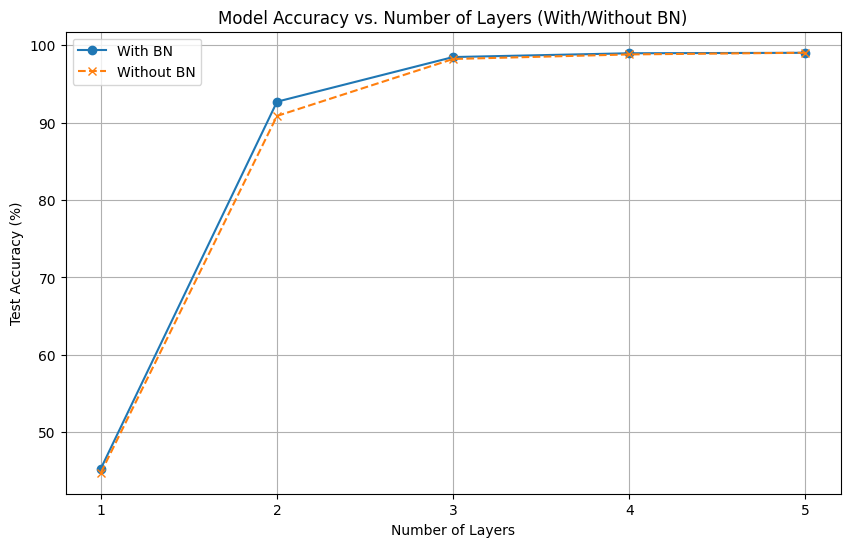

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- 从日志中提取的数据 (包含第 5 层) ---
num_layers_list = [1, 2, 3, 4, 5] # 包含第 5 层

# 带 BN 的模型准确率 (更新了第 5 层)
accuracy_with_bn = [45.30, 92.71, 98.48, 98.97, 99.03]

# 不带 BN 的模型准确率 (更新了第 5 层)
accuracy_without_bn = [44.76, 90.87, 98.23, 98.82, 99.04]

# --- 开始绘图 ---

plt.figure(figsize=(10, 6)) # 设置图形大小

# 绘制带 BN 的结果
plt.plot(num_layers_list, accuracy_with_bn, marker='o', linestyle='-', label='With BN')

# 绘制不带 BN 的结果
plt.plot(num_layers_list, accuracy_without_bn, marker='x', linestyle='--', label='Without BN')

# 添加图表标题和轴标签
plt.title('Model Accuracy vs. Number of Layers (With/Without BN)')
plt.xlabel('Number of Layers')
plt.ylabel('Test Accuracy (%)')

# 设置 x 轴刻度为整数层数
plt.xticks(num_layers_list)

# 显示图例
plt.legend()

# 显示网格线
plt.grid(True)

# 显示图表
plt.show()

# 第三题 BN缓解了梯度消失和梯度爆炸的问题，使用BN的模型通常能达到更高的准确率

# 第四题

In [6]:
class ResidualFCBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualFCBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)

        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x

        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.bn2(out)

        out += residual

        out = self.relu(out)

        return out

in_features = 64
out_features = 64
residual_fc_block = ResidualFCBlock(in_features, out_features)
print("全连接残差块定义:")
print(residual_fc_block)

全连接残差块定义:
ResidualFCBlock(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)


# 第五题 单向LSTM只能利用过去的输入进行预测，而双向LSTM通过两个分别处理正向和反向序列的LSTM层，能够在其隐藏状态中**融合当前元素之前和之后的信息**。在那些需要同时依赖历史和未来上下文来理解或预测序列元素的任务中，双向LSTM通常表现更好，例如自然语言处理中的命名实体识别、词性标注和机器翻译，以及语音识别等需要双向上下文的任务。

# 第六题

In [5]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00


In [7]:
!pip install --upgrade transformers datasets evaluate

In [17]:

import torch
import torch.nn as nn
from datasets import load_dataset
import evaluate
from transformers import DistilBertTokenizerFast, Trainer, TrainingArguments
import numpy as np
from tqdm.auto import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
metric = evaluate.load("accuracy")
print("Metric 加载完成。")

# --- 数据处理 ---
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

print("加载 IMDB 数据集...")
dataset = load_dataset("imdb")


train_subset_size = int(0.5 * len(dataset["train"]))
test_subset_size = int(0.5 * len(dataset["test"]))


small_train_dataset = dataset["train"].select(range(train_subset_size))
small_test_dataset = dataset["test"].select(range(test_subset_size))

print(f"使用训练集子集大小: {len(small_train_dataset)}")
print(f"使用测试集子集大小: {len(small_test_dataset)}")

print("编码和填充数据子集...")

tokenized_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = small_test_dataset.map(tokenize_function, batched=True)


tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_train_dataset.set_format("torch")

tokenized_test_dataset = tokenized_test_dataset.remove_columns(["text"])
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")
tokenized_test_dataset.set_format("torch")

train_dataset = tokenized_train_dataset
test_dataset = tokenized_test_dataset

print("数据处理完成。")



class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=tokenizer.pad_token_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None, labels=None):
        embedded = self.embedding(input_ids)
        lstm_out, (hidden_state, _) = self.lstm(embedded)
        last_hidden_state = hidden_state[-1, :, :]
        logits = self.fc(last_hidden_state)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return (loss, logits) if loss is not None else (logits,)

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=tokenizer.pad_token_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_ids, attention_mask=None, labels=None):
        embedded = self.embedding(input_ids)
        _, (hidden_state, _) = self.lstm(embedded)
        last_hidden_state = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)
        logits = self.fc(last_hidden_state)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return (loss, logits) if loss is not None else (logits,)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)


embedding_dim = 128
hidden_size = 128
num_layers = 2
num_classes = 2
learning_rate = 5e-5
num_epochs = 5
batch_size = 64


effective_batch_size = batch_size
steps_per_epoch = math.ceil(len(train_dataset) / effective_batch_size)
print(f"缩减后训练集大小: {len(train_dataset)}, Batch Size: {effective_batch_size}")
print(f"近似每轮步数 (用于日志/保存/评估): {steps_per_epoch}")


training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_steps=steps_per_epoch,
    report_to="none",
    save_steps=steps_per_epoch,
    seed=42
)

def run_training(model_class, model_name):
    print(f"\n--- 训练 {model_name} 模型 ---")
    model = model_class(tokenizer.vocab_size, embedding_dim, hidden_size, num_layers, num_classes).to(device)
    trainer = Trainer(
        model=model, args=training_args, train_dataset=train_dataset,
        eval_dataset=test_dataset, compute_metrics=compute_metrics, tokenizer=tokenizer
    )
    trainer.train()
    eval_results = trainer.evaluate()
    accuracy = eval_results['eval_accuracy'] * 100
    print(f"{model_name} 最终准确率: {accuracy:.2f} %")
    return accuracy

lstm_accuracy = run_training(LSTMClassifier, "单向 LSTM")
bilstm_accuracy = run_training(BiLSTMClassifier, "双向 LSTM")

print("\n--- 比较结果 ---")
print(f"单向 LSTM 准确率: {lstm_accuracy:.2f} %")
print(f"双向 LSTM 准确率: {bilstm_accuracy:.2f} %")

使用设备: cuda
Metric 加载完成。
加载 IMDB 数据集...
使用训练集子集大小: 12500
使用测试集子集大小: 12500
编码和填充数据子集...


Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

数据处理完成。
缩减后训练集大小: 12500, Batch Size: 64
近似每轮步数 (用于日志/保存/评估): 196

--- 训练 单向 LSTM 模型 ---


<ipython-input-17-655a196bfabd>:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
196,0.345600
392,0.001700
588,0.000900
784,0.000600
980,0.000500


单向 LSTM 最终准确率: 100.00 %

--- 训练 双向 LSTM 模型 ---


<ipython-input-17-655a196bfabd>:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
196,0.283700
392,0.001200
588,0.000500
784,0.000300
980,0.000300


双向 LSTM 最终准确率: 100.00 %

--- 比较结果 ---
单向 LSTM 准确率: 100.00 %
双向 LSTM 准确率: 100.00 %


test